In [ ]:
import torch;
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import pandas as pd
import torchvision.models as models 
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.optim import lr_scheduler
import seaborn as sns
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import copy
from tqdm import tqdm
#from model import VAE

import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from dataloader_pw import *
from cnn_model_1 import *

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#only on validation set
csv_path = 'pairwise_lstm.csv'
img_path = '/home/vip/sayan-mandal/datasets/obj_criteria/good_reduced/'

CDL = PWDataLoader(csv_path, img_path, transform = transforms.Compose([transforms.Resize(64),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

#random sampler
batch_size = 64
validation_split = .2
test_split = .2
train_split = 1-validation_split-test_split
shuffle_dataset = True

# Creating data indices for training and validation splits:
dataset_size = len(CDL)
indices = list(range(dataset_size))
split_train = int(np.floor(train_split * dataset_size))
split_valid = int(np.floor((train_split+validation_split) * dataset_size))
if shuffle_dataset :
    np.random.shuffle(indices)
train_indices, val_indices, test_indices =  indices[:split_train],indices[split_train:split_valid],indices[split_valid:]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=test_sampler)

<AxesSubplot:xlabel='Slope ($\\mu$m/y)', ylabel='Count'>

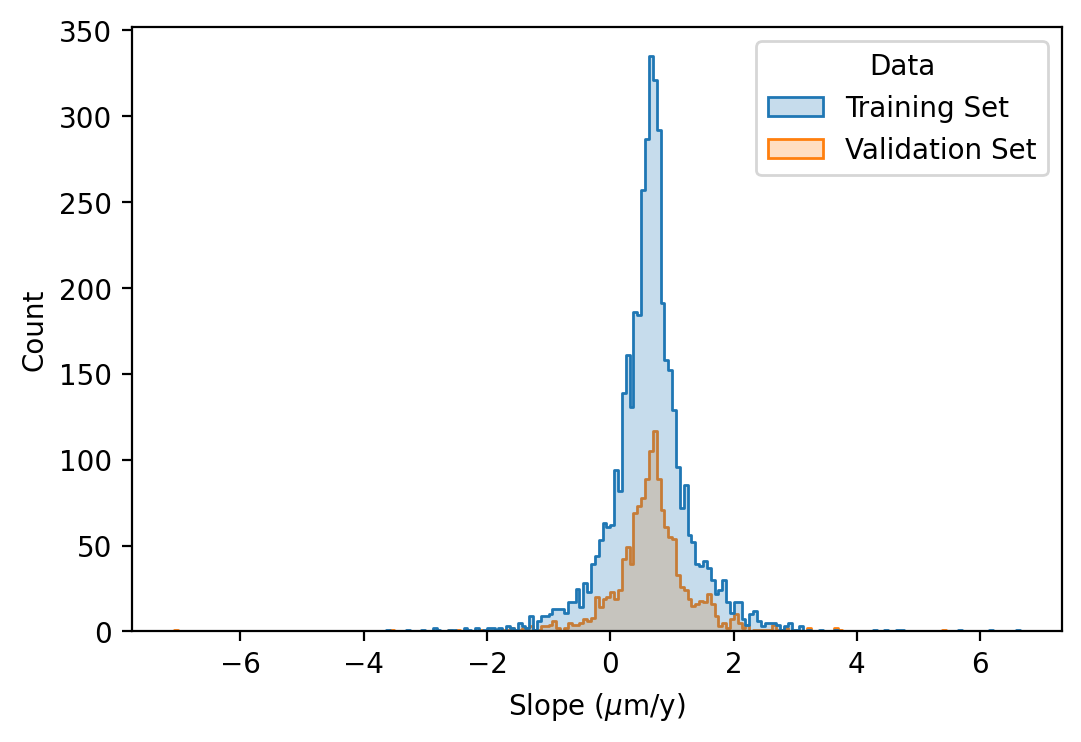

In [4]:

for batch_idx, (_, targets, _) in enumerate(train_loader):
    targets = Variable(targets.view(targets.shape[0],-1))

    if batch_idx == 0:
        true_scores = targets.cpu().numpy()
    else:
        true_scores = np.append(true_scores, targets.cpu().numpy(), axis = 0)

for batch_idx, (_, targets, _) in enumerate(valid_loader):
    targets = Variable(targets.view(targets.shape[0],-1))

    if batch_idx == 0:
        valtrue_scores = targets.cpu().numpy()
    else:
        valtrue_scores = np.append(valtrue_scores, targets.cpu().numpy(), axis = 0)

from scipy.stats import ks_2samp
dfx = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': true_scores.ravel().tolist(), 'Data':'Training Set'})
dfy = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': valtrue_scores.ravel().tolist(), 'Data':'Validation Set'})
df = pd.concat(axis=0, ignore_index=True, objs=[dfx,dfy])



fig,ax = plt.subplots()
sns.histplot(df,x='Slope ($\mu$m/y)',hue='Data',ax=ax, element='step')


In [5]:
print(len(true_scores), len(valtrue_scores))

4445 1482


In [17]:
torch.cuda.empty_cache()
tl = iter(train_loader)
dat,_,_ = next(tl)
bs, ts, C, H, W = dat.shape
n_out = 1
print(ts)

model = CNNLSTMNet(channels = C, ts = ts, n_out = n_out, device = device).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1)  #,momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[120], gamma= 0.1)
criterion = nn.MSELoss()  # this is for regression mean squared loss

2


In [18]:
epochs = 200
best_loss =float('inf')
ep, trainloss, validloss, testloss = [],[],[],[]
testep, totloss = [],[]
besttrloss, bestvalloss, besttsloss = 0,0,0
for epoch in range(1,epochs+1):
    model.train()
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    trloss = 0
    for batch_idx, (data, targets, _) in loop:
        optimizer.zero_grad() 
        data = Variable(data).to(device)
        targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

        #forward pass
        scores = model(data)
        loss = criterion(scores, targets)
        trloss += loss.item()
        #backward pass   
        loss.backward()

        #gradient descent
        optimizer.step()
        loop.set_description(f"Epoch [{epoch}/{epochs}]")
        loop.set_postfix(batch_loss = loss.item(), running_loss = trloss )
    scheduler.step()

    model.eval()
    valloss = 0
    with torch.no_grad():
        for data, targets, _ in valid_loader:
            data = Variable(data).to(device)
            targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

            
            scores = model(data)
            loss = criterion(scores, targets)

            valloss += loss.item()

    if valloss < best_loss:
        tsloss = 0
        with torch.no_grad():
            for data, targets, _ in test_loader:
                data = Variable(data).to(device)
                targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

                
                scores = model(data)
                loss = criterion(scores, targets)

                tsloss += loss.item()
            testloss += [tsloss]
            testep += [epoch]
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f} ===========> {:.4f} | Test Loss: {:.4f} | Saving model...".format(trloss, best_loss, valloss, tsloss)
        best_loss = valloss
        bestvalloss = valloss
        besttrloss = trloss
        besttsloss = tsloss
        best_e = epoch
        torch.save(model.state_dict(),'pw_statedict.pt')
        #best_model = copy.deepcopy(model)
    else:
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f}".format(trloss, valloss)

    print(to_print)
    ep+=[epoch]
    trainloss += [trloss]
    validloss += [valloss]
    totloss += [trloss + valloss]

Epoch [1/200]: 100%|██████████| 70/70 [00:09<00:00,  7.49it/s, batch_loss=0.473, running_loss=31.5]


Train Loss: 31.5269 | Valid Loss: inf ===========> 11.0907 | Test Loss: 11.7088 | Saving model...


Epoch [2/200]: 100%|██████████| 70/70 [00:09<00:00,  7.38it/s, batch_loss=0.209, running_loss=30.3]


Train Loss: 30.3027 | Valid Loss: 11.0907 ===========> 10.6244 | Test Loss: 11.4918 | Saving model...


Epoch [3/200]: 100%|██████████| 70/70 [00:09<00:00,  7.49it/s, batch_loss=0.462, running_loss=29.7]


Train Loss: 29.7422 | Valid Loss: 10.6244 ===========> 10.4291 | Test Loss: 11.7486 | Saving model...


Epoch [4/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.403, running_loss=28.8]


Train Loss: 28.7608 | Valid Loss: 10.4291 ===========> 10.3096 | Test Loss: 10.7614 | Saving model...


Epoch [5/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.137, running_loss=28]


Train Loss: 27.9536 | Valid Loss: 10.3929


Epoch [6/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.241, running_loss=25.8]


Train Loss: 25.8156 | Valid Loss: 10.9113


Epoch [7/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.216, running_loss=25.7]


Train Loss: 25.6710 | Valid Loss: 10.3096 ===========> 9.0568 | Test Loss: 9.2417 | Saving model...


Epoch [8/200]: 100%|██████████| 70/70 [00:09<00:00,  7.57it/s, batch_loss=0.518, running_loss=23.5]


Train Loss: 23.4863 | Valid Loss: 10.5145


Epoch [9/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.297, running_loss=22.1]


Train Loss: 22.0715 | Valid Loss: 9.7542


Epoch [10/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.221, running_loss=20.6]


Train Loss: 20.5888 | Valid Loss: 9.3693


Epoch [11/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.191, running_loss=19.7]


Train Loss: 19.7192 | Valid Loss: 9.6842


Epoch [12/200]: 100%|██████████| 70/70 [00:09<00:00,  7.59it/s, batch_loss=0.274, running_loss=18.3]


Train Loss: 18.2967 | Valid Loss: 9.0568 ===========> 7.8170 | Test Loss: 7.2029 | Saving model...


Epoch [13/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.335, running_loss=17.6]


Train Loss: 17.5626 | Valid Loss: 14.6199


Epoch [14/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.182, running_loss=16.8]


Train Loss: 16.8163 | Valid Loss: 7.9567


Epoch [15/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.211, running_loss=15.9]


Train Loss: 15.8693 | Valid Loss: 10.2108


Epoch [16/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.181, running_loss=14.9]


Train Loss: 14.9048 | Valid Loss: 8.1319


Epoch [17/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.0818, running_loss=13.8]


Train Loss: 13.7593 | Valid Loss: 7.8170 ===========> 7.3715 | Test Loss: 6.7667 | Saving model...


Epoch [18/200]: 100%|██████████| 70/70 [00:09<00:00,  7.59it/s, batch_loss=0.148, running_loss=13.8]


Train Loss: 13.7634 | Valid Loss: 7.5615


Epoch [19/200]: 100%|██████████| 70/70 [00:09<00:00,  7.59it/s, batch_loss=0.0992, running_loss=11.9]


Train Loss: 11.8539 | Valid Loss: 7.5296


Epoch [20/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.143, running_loss=11.6]


Train Loss: 11.6201 | Valid Loss: 7.9503


Epoch [21/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.228, running_loss=11.6]


Train Loss: 11.6164 | Valid Loss: 10.0639


Epoch [22/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.392, running_loss=11.3]


Train Loss: 11.2916 | Valid Loss: 10.3166


Epoch [23/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.134, running_loss=10.2]


Train Loss: 10.2082 | Valid Loss: 8.2193


Epoch [24/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.134, running_loss=10.2]


Train Loss: 10.2381 | Valid Loss: 7.9592


Epoch [25/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.302, running_loss=9.18]


Train Loss: 9.1843 | Valid Loss: 11.9745


Epoch [26/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0961, running_loss=8.55]


Train Loss: 8.5480 | Valid Loss: 7.6633


Epoch [27/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.199, running_loss=8.93]


Train Loss: 8.9308 | Valid Loss: 7.3715 ===========> 7.0718 | Test Loss: 6.1589 | Saving model...


Epoch [28/200]: 100%|██████████| 70/70 [00:09<00:00,  7.58it/s, batch_loss=0.0625, running_loss=7.88]


Train Loss: 7.8768 | Valid Loss: 7.0718 ===========> 7.0470 | Test Loss: 6.0366 | Saving model...


Epoch [29/200]: 100%|██████████| 70/70 [00:09<00:00,  7.56it/s, batch_loss=0.129, running_loss=7.42]


Train Loss: 7.4161 | Valid Loss: 7.9157


Epoch [30/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.07, running_loss=7.13]


Train Loss: 7.1287 | Valid Loss: 7.0470 ===========> 6.8003 | Test Loss: 5.5808 | Saving model...


Epoch [31/200]: 100%|██████████| 70/70 [00:09<00:00,  7.58it/s, batch_loss=0.132, running_loss=6.57]


Train Loss: 6.5657 | Valid Loss: 7.5338


Epoch [32/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.13, running_loss=6.33]


Train Loss: 6.3280 | Valid Loss: 6.8003 ===========> 6.7106 | Test Loss: 5.7156 | Saving model...


Epoch [33/200]: 100%|██████████| 70/70 [00:09<00:00,  7.58it/s, batch_loss=0.0838, running_loss=6.34]


Train Loss: 6.3379 | Valid Loss: 8.1974


Epoch [34/200]: 100%|██████████| 70/70 [00:09<00:00,  7.57it/s, batch_loss=0.148, running_loss=5.57]


Train Loss: 5.5708 | Valid Loss: 7.4817


Epoch [35/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.0888, running_loss=5.14]


Train Loss: 5.1378 | Valid Loss: 6.7106 ===========> 6.6168 | Test Loss: 5.4703 | Saving model...


Epoch [36/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0741, running_loss=4.86]


Train Loss: 4.8577 | Valid Loss: 7.7028


Epoch [37/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.0548, running_loss=4.4]


Train Loss: 4.3982 | Valid Loss: 6.6295


Epoch [38/200]: 100%|██████████| 70/70 [00:09<00:00,  7.59it/s, batch_loss=0.0859, running_loss=4.43]


Train Loss: 4.4346 | Valid Loss: 6.7711


Epoch [39/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.074, running_loss=4.44]


Train Loss: 4.4354 | Valid Loss: 7.1627


Epoch [40/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.0319, running_loss=4.16]


Train Loss: 4.1617 | Valid Loss: 6.6168 ===========> 6.5991 | Test Loss: 5.7872 | Saving model...


Epoch [41/200]: 100%|██████████| 70/70 [00:09<00:00,  7.57it/s, batch_loss=0.0271, running_loss=3.98]


Train Loss: 3.9762 | Valid Loss: 6.5991 ===========> 6.4188 | Test Loss: 5.4783 | Saving model...


Epoch [42/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.043, running_loss=3.69]


Train Loss: 3.6888 | Valid Loss: 6.4188 ===========> 6.3710 | Test Loss: 5.6400 | Saving model...


Epoch [43/200]: 100%|██████████| 70/70 [00:09<00:00,  7.37it/s, batch_loss=0.0841, running_loss=3.6]


Train Loss: 3.6047 | Valid Loss: 6.5774


Epoch [44/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0566, running_loss=3.79]


Train Loss: 3.7906 | Valid Loss: 6.4542


Epoch [45/200]: 100%|██████████| 70/70 [00:09<00:00,  7.59it/s, batch_loss=0.0248, running_loss=3.26]


Train Loss: 3.2616 | Valid Loss: 6.7254


Epoch [46/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0297, running_loss=3.31]


Train Loss: 3.3103 | Valid Loss: 6.4900


Epoch [47/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0453, running_loss=3.08]


Train Loss: 3.0750 | Valid Loss: 6.4355


Epoch [48/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0491, running_loss=3.11]


Train Loss: 3.1138 | Valid Loss: 6.4790


Epoch [49/200]: 100%|██████████| 70/70 [00:09<00:00,  7.75it/s, batch_loss=0.029, running_loss=2.9]


Train Loss: 2.9004 | Valid Loss: 6.7632


Epoch [50/200]: 100%|██████████| 70/70 [00:09<00:00,  7.59it/s, batch_loss=0.0366, running_loss=2.89]


Train Loss: 2.8865 | Valid Loss: 6.9453


Epoch [51/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0479, running_loss=2.81]


Train Loss: 2.8116 | Valid Loss: 6.5136


Epoch [52/200]: 100%|██████████| 70/70 [00:09<00:00,  7.72it/s, batch_loss=0.0437, running_loss=2.78]


Train Loss: 2.7789 | Valid Loss: 7.7266


Epoch [53/200]: 100%|██████████| 70/70 [00:09<00:00,  7.71it/s, batch_loss=0.0231, running_loss=2.55]


Train Loss: 2.5534 | Valid Loss: 6.3710 ===========> 6.3023 | Test Loss: 5.4516 | Saving model...


Epoch [54/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.0409, running_loss=2.57]


Train Loss: 2.5708 | Valid Loss: 6.4035


Epoch [55/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.034, running_loss=2.6]


Train Loss: 2.5986 | Valid Loss: 6.3144


Epoch [56/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0305, running_loss=2.66]


Train Loss: 2.6598 | Valid Loss: 7.1128


Epoch [57/200]: 100%|██████████| 70/70 [00:09<00:00,  7.74it/s, batch_loss=0.0391, running_loss=2.45]


Train Loss: 2.4512 | Valid Loss: 6.6597


Epoch [58/200]: 100%|██████████| 70/70 [00:09<00:00,  7.74it/s, batch_loss=0.0319, running_loss=2.42]


Train Loss: 2.4178 | Valid Loss: 6.3023 ===========> 6.2928 | Test Loss: 5.2714 | Saving model...


Epoch [59/200]: 100%|██████████| 70/70 [00:09<00:00,  7.72it/s, batch_loss=0.0492, running_loss=2.4]


Train Loss: 2.3952 | Valid Loss: 6.3755


Epoch [60/200]: 100%|██████████| 70/70 [00:09<00:00,  7.74it/s, batch_loss=0.0301, running_loss=2.28]


Train Loss: 2.2774 | Valid Loss: 6.2928 ===========> 6.1421 | Test Loss: 5.4643 | Saving model...


Epoch [61/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0281, running_loss=2.35]


Train Loss: 2.3549 | Valid Loss: 6.2464


Epoch [62/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0405, running_loss=2.3]


Train Loss: 2.3038 | Valid Loss: 6.2405


Epoch [63/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0245, running_loss=2.23]


Train Loss: 2.2279 | Valid Loss: 6.2637


Epoch [64/200]: 100%|██████████| 70/70 [00:09<00:00,  7.72it/s, batch_loss=0.0229, running_loss=2.17]


Train Loss: 2.1734 | Valid Loss: 6.1744


Epoch [65/200]: 100%|██████████| 70/70 [00:09<00:00,  7.71it/s, batch_loss=0.0306, running_loss=2.13]


Train Loss: 2.1326 | Valid Loss: 6.3688


Epoch [66/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0475, running_loss=2.18]


Train Loss: 2.1820 | Valid Loss: 6.1421 ===========> 6.0280 | Test Loss: 5.5982 | Saving model...


Epoch [67/200]: 100%|██████████| 70/70 [00:09<00:00,  7.71it/s, batch_loss=0.0141, running_loss=2.13]


Train Loss: 2.1330 | Valid Loss: 6.1792


Epoch [68/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0423, running_loss=2]


Train Loss: 1.9950 | Valid Loss: 6.1513


Epoch [69/200]: 100%|██████████| 70/70 [00:09<00:00,  7.72it/s, batch_loss=0.0479, running_loss=2.1]


Train Loss: 2.0977 | Valid Loss: 6.1168


Epoch [70/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0324, running_loss=2.17]


Train Loss: 2.1669 | Valid Loss: 6.1217


Epoch [71/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0471, running_loss=1.99]


Train Loss: 1.9914 | Valid Loss: 6.1199


Epoch [72/200]: 100%|██████████| 70/70 [00:09<00:00,  7.74it/s, batch_loss=0.0447, running_loss=2.02]


Train Loss: 2.0178 | Valid Loss: 6.5939


Epoch [73/200]: 100%|██████████| 70/70 [00:09<00:00,  7.72it/s, batch_loss=0.0489, running_loss=1.95]


Train Loss: 1.9479 | Valid Loss: 6.1340


Epoch [74/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0287, running_loss=2.01]


Train Loss: 2.0107 | Valid Loss: 6.0298


Epoch [75/200]: 100%|██████████| 70/70 [00:09<00:00,  7.71it/s, batch_loss=0.0304, running_loss=1.94]


Train Loss: 1.9374 | Valid Loss: 6.2834


Epoch [76/200]: 100%|██████████| 70/70 [00:09<00:00,  7.71it/s, batch_loss=0.0291, running_loss=2.02]


Train Loss: 2.0193 | Valid Loss: 6.2140


Epoch [77/200]: 100%|██████████| 70/70 [00:09<00:00,  7.75it/s, batch_loss=0.0352, running_loss=1.85]


Train Loss: 1.8473 | Valid Loss: 6.1905


Epoch [78/200]: 100%|██████████| 70/70 [00:09<00:00,  7.72it/s, batch_loss=0.024, running_loss=1.88]


Train Loss: 1.8804 | Valid Loss: 6.6331


Epoch [79/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.094, running_loss=1.97]


Train Loss: 1.9671 | Valid Loss: 6.1613


Epoch [80/200]: 100%|██████████| 70/70 [00:09<00:00,  7.71it/s, batch_loss=0.0272, running_loss=1.85]


Train Loss: 1.8454 | Valid Loss: 6.3855


Epoch [81/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0225, running_loss=1.81]


Train Loss: 1.8145 | Valid Loss: 6.2068


Epoch [82/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0154, running_loss=1.88]


Train Loss: 1.8796 | Valid Loss: 6.1520


Epoch [83/200]: 100%|██████████| 70/70 [00:09<00:00,  7.73it/s, batch_loss=0.0261, running_loss=1.85]


Train Loss: 1.8472 | Valid Loss: 6.0564


Epoch [84/200]: 100%|██████████| 70/70 [00:09<00:00,  7.74it/s, batch_loss=0.0221, running_loss=1.75]


Train Loss: 1.7528 | Valid Loss: 6.3509


Epoch [85/200]: 100%|██████████| 70/70 [00:09<00:00,  7.74it/s, batch_loss=0.0169, running_loss=1.78]


Train Loss: 1.7763 | Valid Loss: 6.0503


Epoch [86/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0416, running_loss=1.74]


Train Loss: 1.7351 | Valid Loss: 6.1827


Epoch [87/200]: 100%|██████████| 70/70 [00:09<00:00,  7.75it/s, batch_loss=0.0289, running_loss=1.76]


Train Loss: 1.7595 | Valid Loss: 6.1979


Epoch [88/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0336, running_loss=1.69]


Train Loss: 1.6924 | Valid Loss: 6.3211


Epoch [89/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.0508, running_loss=1.73]


Train Loss: 1.7340 | Valid Loss: 6.1445


Epoch [90/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0095, running_loss=1.73]


Train Loss: 1.7271 | Valid Loss: 6.1863


Epoch [91/200]: 100%|██████████| 70/70 [00:09<00:00,  7.73it/s, batch_loss=0.0266, running_loss=1.79]


Train Loss: 1.7949 | Valid Loss: 6.1359


Epoch [92/200]: 100%|██████████| 70/70 [00:09<00:00,  7.71it/s, batch_loss=0.0147, running_loss=1.69]


Train Loss: 1.6906 | Valid Loss: 6.0342


Epoch [93/200]: 100%|██████████| 70/70 [00:09<00:00,  7.71it/s, batch_loss=0.0279, running_loss=1.76]


Train Loss: 1.7630 | Valid Loss: 6.2085


Epoch [94/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0355, running_loss=1.69]


Train Loss: 1.6898 | Valid Loss: 6.0280 ===========> 6.0277 | Test Loss: 5.1565 | Saving model...


Epoch [95/200]: 100%|██████████| 70/70 [00:09<00:00,  7.71it/s, batch_loss=0.0295, running_loss=1.67]


Train Loss: 1.6740 | Valid Loss: 6.1760


Epoch [96/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0246, running_loss=1.67]


Train Loss: 1.6726 | Valid Loss: 6.0703


Epoch [97/200]: 100%|██████████| 70/70 [00:09<00:00,  7.73it/s, batch_loss=0.0126, running_loss=1.69]


Train Loss: 1.6914 | Valid Loss: 6.0757


Epoch [98/200]: 100%|██████████| 70/70 [00:09<00:00,  7.74it/s, batch_loss=0.0269, running_loss=1.61]


Train Loss: 1.6135 | Valid Loss: 6.0710


Epoch [99/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0282, running_loss=1.64]


Train Loss: 1.6433 | Valid Loss: 6.2476


Epoch [100/200]: 100%|██████████| 70/70 [00:09<00:00,  7.71it/s, batch_loss=0.0284, running_loss=1.7]


Train Loss: 1.6983 | Valid Loss: 6.1350


Epoch [101/200]: 100%|██████████| 70/70 [00:09<00:00,  7.71it/s, batch_loss=0.0173, running_loss=1.54]


Train Loss: 1.5409 | Valid Loss: 6.3455


Epoch [102/200]: 100%|██████████| 70/70 [00:09<00:00,  7.72it/s, batch_loss=0.0757, running_loss=1.65]


Train Loss: 1.6524 | Valid Loss: 6.1446


Epoch [103/200]: 100%|██████████| 70/70 [00:09<00:00,  7.75it/s, batch_loss=0.0129, running_loss=1.63]


Train Loss: 1.6274 | Valid Loss: 6.2122


Epoch [104/200]: 100%|██████████| 70/70 [00:09<00:00,  7.75it/s, batch_loss=0.0101, running_loss=1.58]


Train Loss: 1.5756 | Valid Loss: 6.1902


Epoch [105/200]: 100%|██████████| 70/70 [00:09<00:00,  7.74it/s, batch_loss=0.0161, running_loss=1.55]


Train Loss: 1.5549 | Valid Loss: 6.2353


Epoch [106/200]: 100%|██████████| 70/70 [00:09<00:00,  7.75it/s, batch_loss=0.0255, running_loss=1.56]


Train Loss: 1.5620 | Valid Loss: 6.1104


Epoch [107/200]: 100%|██████████| 70/70 [00:09<00:00,  7.75it/s, batch_loss=0.0303, running_loss=1.59]


Train Loss: 1.5856 | Valid Loss: 6.0277 ===========> 6.0025 | Test Loss: 5.1868 | Saving model...


Epoch [108/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0266, running_loss=1.54]


Train Loss: 1.5432 | Valid Loss: 7.2660


Epoch [109/200]: 100%|██████████| 70/70 [00:09<00:00,  7.73it/s, batch_loss=0.0318, running_loss=1.56]


Train Loss: 1.5642 | Valid Loss: 6.1528


Epoch [110/200]: 100%|██████████| 70/70 [00:09<00:00,  7.72it/s, batch_loss=0.0514, running_loss=1.62]


Train Loss: 1.6184 | Valid Loss: 6.1598


Epoch [111/200]: 100%|██████████| 70/70 [00:09<00:00,  7.73it/s, batch_loss=0.0185, running_loss=1.52]


Train Loss: 1.5234 | Valid Loss: 6.1679


Epoch [112/200]: 100%|██████████| 70/70 [00:09<00:00,  7.50it/s, batch_loss=0.0143, running_loss=1.55]


Train Loss: 1.5504 | Valid Loss: 6.1636


Epoch [113/200]: 100%|██████████| 70/70 [00:09<00:00,  7.44it/s, batch_loss=0.031, running_loss=1.51]


Train Loss: 1.5090 | Valid Loss: 6.0815


Epoch [114/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.056, running_loss=1.57]


Train Loss: 1.5713 | Valid Loss: 6.0854


Epoch [115/200]: 100%|██████████| 70/70 [00:09<00:00,  7.57it/s, batch_loss=0.0158, running_loss=1.5]


Train Loss: 1.5037 | Valid Loss: 6.1835


Epoch [116/200]: 100%|██████████| 70/70 [00:09<00:00,  7.59it/s, batch_loss=0.0114, running_loss=1.48]


Train Loss: 1.4804 | Valid Loss: 6.2407


Epoch [117/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.0091, running_loss=1.49]


Train Loss: 1.4948 | Valid Loss: 6.1173


Epoch [118/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.0282, running_loss=1.52]


Train Loss: 1.5212 | Valid Loss: 6.8429


Epoch [119/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0116, running_loss=1.53]


Train Loss: 1.5305 | Valid Loss: 6.3150


Epoch [120/200]: 100%|██████████| 70/70 [00:09<00:00,  7.56it/s, batch_loss=0.0575, running_loss=1.58]


Train Loss: 1.5790 | Valid Loss: 6.1716


Epoch [121/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0426, running_loss=1.38]


Train Loss: 1.3813 | Valid Loss: 6.1074


Epoch [122/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0145, running_loss=1.38]


Train Loss: 1.3761 | Valid Loss: 6.3094


Epoch [123/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0245, running_loss=1.29]


Train Loss: 1.2876 | Valid Loss: 6.1972


Epoch [124/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0185, running_loss=1.31]


Train Loss: 1.3069 | Valid Loss: 6.4739


Epoch [125/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0189, running_loss=1.3]


Train Loss: 1.3040 | Valid Loss: 6.0645


Epoch [126/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0247, running_loss=1.3]


Train Loss: 1.2968 | Valid Loss: 6.0875


Epoch [127/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.0466, running_loss=1.31]


Train Loss: 1.3091 | Valid Loss: 6.2414


Epoch [128/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.0297, running_loss=1.27]


Train Loss: 1.2663 | Valid Loss: 6.8237


Epoch [129/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0113, running_loss=1.23]


Train Loss: 1.2326 | Valid Loss: 6.0962


Epoch [130/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0227, running_loss=1.26]


Train Loss: 1.2647 | Valid Loss: 6.4086


Epoch [131/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0222, running_loss=1.29]


Train Loss: 1.2935 | Valid Loss: 6.0639


Epoch [132/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0184, running_loss=1.26]


Train Loss: 1.2624 | Valid Loss: 6.1737


Epoch [133/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0373, running_loss=1.25]


Train Loss: 1.2533 | Valid Loss: 6.1540


Epoch [134/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.00897, running_loss=1.28]


Train Loss: 1.2802 | Valid Loss: 6.1048


Epoch [135/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0226, running_loss=1.23]


Train Loss: 1.2272 | Valid Loss: 6.0773


Epoch [136/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.0116, running_loss=1.23]


Train Loss: 1.2340 | Valid Loss: 6.2465


Epoch [137/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0157, running_loss=1.2]


Train Loss: 1.2047 | Valid Loss: 6.0783


Epoch [138/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0181, running_loss=1.27]


Train Loss: 1.2726 | Valid Loss: 6.0967


Epoch [139/200]: 100%|██████████| 70/70 [00:09<00:00,  7.58it/s, batch_loss=0.0757, running_loss=1.26]


Train Loss: 1.2614 | Valid Loss: 6.2139


Epoch [140/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0215, running_loss=1.26]


Train Loss: 1.2624 | Valid Loss: 6.0829


Epoch [141/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0129, running_loss=1.23]


Train Loss: 1.2322 | Valid Loss: 6.3128


Epoch [142/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0253, running_loss=1.23]


Train Loss: 1.2305 | Valid Loss: 6.0345


Epoch [143/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0327, running_loss=1.24]


Train Loss: 1.2401 | Valid Loss: 6.2182


Epoch [144/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0209, running_loss=1.21]


Train Loss: 1.2111 | Valid Loss: 6.1864


Epoch [145/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0239, running_loss=1.22]


Train Loss: 1.2197 | Valid Loss: 6.0908


Epoch [146/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0101, running_loss=1.26]


Train Loss: 1.2576 | Valid Loss: 6.1362


Epoch [147/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.00982, running_loss=1.25]


Train Loss: 1.2539 | Valid Loss: 6.0752


Epoch [148/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0085, running_loss=1.29]


Train Loss: 1.2948 | Valid Loss: 6.1823


Epoch [149/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0164, running_loss=1.25]


Train Loss: 1.2484 | Valid Loss: 6.1030


Epoch [150/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0169, running_loss=1.21]


Train Loss: 1.2140 | Valid Loss: 6.1061


Epoch [151/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.025, running_loss=1.23]


Train Loss: 1.2349 | Valid Loss: 6.0582


Epoch [152/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0177, running_loss=1.22]


Train Loss: 1.2198 | Valid Loss: 6.0356


Epoch [153/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0248, running_loss=1.27]


Train Loss: 1.2673 | Valid Loss: 6.0588


Epoch [154/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.00876, running_loss=1.18]


Train Loss: 1.1846 | Valid Loss: 6.0703


Epoch [155/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0212, running_loss=1.21]


Train Loss: 1.2100 | Valid Loss: 6.1131


Epoch [156/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0053, running_loss=1.2]


Train Loss: 1.2003 | Valid Loss: 6.1617


Epoch [157/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0119, running_loss=1.2]


Train Loss: 1.1986 | Valid Loss: 10.4806


Epoch [158/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0136, running_loss=1.26]


Train Loss: 1.2601 | Valid Loss: 6.0694


Epoch [159/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0121, running_loss=1.18]


Train Loss: 1.1769 | Valid Loss: 6.2740


Epoch [160/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.0163, running_loss=1.2]


Train Loss: 1.2040 | Valid Loss: 6.9749


Epoch [161/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0224, running_loss=1.25]


Train Loss: 1.2464 | Valid Loss: 6.3286


Epoch [162/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.02, running_loss=1.25]


Train Loss: 1.2457 | Valid Loss: 6.1032


Epoch [163/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0469, running_loss=1.23]


Train Loss: 1.2326 | Valid Loss: 6.1448


Epoch [164/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0138, running_loss=1.25]


Train Loss: 1.2450 | Valid Loss: 6.1128


Epoch [165/200]: 100%|██████████| 70/70 [00:09<00:00,  7.59it/s, batch_loss=0.0121, running_loss=1.21]


Train Loss: 1.2132 | Valid Loss: 6.0372


Epoch [166/200]: 100%|██████████| 70/70 [00:09<00:00,  7.59it/s, batch_loss=0.0118, running_loss=1.24]


Train Loss: 1.2371 | Valid Loss: 6.1347


Epoch [167/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0148, running_loss=1.22]


Train Loss: 1.2226 | Valid Loss: 6.5060


Epoch [168/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0228, running_loss=1.19]


Train Loss: 1.1874 | Valid Loss: 6.1595


Epoch [169/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0243, running_loss=1.2]


Train Loss: 1.1989 | Valid Loss: 6.2758


Epoch [170/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0224, running_loss=1.22]


Train Loss: 1.2205 | Valid Loss: 6.6672


Epoch [171/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0216, running_loss=1.19]


Train Loss: 1.1887 | Valid Loss: 6.3439


Epoch [172/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0235, running_loss=1.21]


Train Loss: 1.2134 | Valid Loss: 6.1023


Epoch [173/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0134, running_loss=1.2]


Train Loss: 1.1966 | Valid Loss: 6.2006


Epoch [174/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0232, running_loss=1.15]


Train Loss: 1.1531 | Valid Loss: 6.2870


Epoch [175/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.00694, running_loss=1.22]


Train Loss: 1.2155 | Valid Loss: 6.1913


Epoch [176/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0209, running_loss=1.2]


Train Loss: 1.1963 | Valid Loss: 6.1427


Epoch [177/200]: 100%|██████████| 70/70 [00:09<00:00,  7.57it/s, batch_loss=0.0171, running_loss=1.2]


Train Loss: 1.1987 | Valid Loss: 6.1073


Epoch [178/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0188, running_loss=1.21]


Train Loss: 1.2102 | Valid Loss: 6.1072


Epoch [179/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.00533, running_loss=1.22]


Train Loss: 1.2188 | Valid Loss: 6.1009


Epoch [180/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0144, running_loss=1.22]


Train Loss: 1.2155 | Valid Loss: 6.0927


Epoch [181/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0171, running_loss=1.25]


Train Loss: 1.2513 | Valid Loss: 6.1752


Epoch [182/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.0188, running_loss=1.21]


Train Loss: 1.2081 | Valid Loss: 6.1669


Epoch [183/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0215, running_loss=1.19]


Train Loss: 1.1950 | Valid Loss: 10.4315


Epoch [184/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.0107, running_loss=1.16]


Train Loss: 1.1603 | Valid Loss: 6.2840


Epoch [185/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0254, running_loss=1.26]


Train Loss: 1.2612 | Valid Loss: 6.0620


Epoch [186/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0267, running_loss=1.21]


Train Loss: 1.2148 | Valid Loss: 6.0519


Epoch [187/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0114, running_loss=1.21]


Train Loss: 1.2096 | Valid Loss: 6.1385


Epoch [188/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0318, running_loss=1.19]


Train Loss: 1.1872 | Valid Loss: 6.0871


Epoch [189/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0401, running_loss=1.22]


Train Loss: 1.2247 | Valid Loss: 6.4867


Epoch [190/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.00724, running_loss=1.22]


Train Loss: 1.2163 | Valid Loss: 6.0751


Epoch [191/200]: 100%|██████████| 70/70 [00:09<00:00,  7.77it/s, batch_loss=0.0319, running_loss=1.28]


Train Loss: 1.2786 | Valid Loss: 6.0397


Epoch [192/200]: 100%|██████████| 70/70 [00:09<00:00,  7.72it/s, batch_loss=0.0269, running_loss=1.18]


Train Loss: 1.1827 | Valid Loss: 6.0375


Epoch [193/200]: 100%|██████████| 70/70 [00:09<00:00,  7.75it/s, batch_loss=0.00842, running_loss=1.21]


Train Loss: 1.2120 | Valid Loss: 6.4220


Epoch [194/200]: 100%|██████████| 70/70 [00:08<00:00,  7.79it/s, batch_loss=0.00967, running_loss=1.24]


Train Loss: 1.2351 | Valid Loss: 6.1798


Epoch [195/200]: 100%|██████████| 70/70 [00:09<00:00,  7.76it/s, batch_loss=0.0307, running_loss=1.2]


Train Loss: 1.1965 | Valid Loss: 6.1127


Epoch [196/200]: 100%|██████████| 70/70 [00:09<00:00,  7.75it/s, batch_loss=0.0123, running_loss=1.23]


Train Loss: 1.2312 | Valid Loss: 6.2968


Epoch [197/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0056, running_loss=1.21]


Train Loss: 1.2103 | Valid Loss: 6.2276


Epoch [198/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0122, running_loss=1.24]


Train Loss: 1.2395 | Valid Loss: 6.1010


Epoch [199/200]: 100%|██████████| 70/70 [00:08<00:00,  7.80it/s, batch_loss=0.0117, running_loss=1.17]


Train Loss: 1.1715 | Valid Loss: 6.1193


Epoch [200/200]: 100%|██████████| 70/70 [00:08<00:00,  7.79it/s, batch_loss=0.0123, running_loss=1.14]


Train Loss: 1.1370 | Valid Loss: 6.5648


Train Loss: 1.5856 | Valid Loss: 6.0025 | Test Loss on Best Model: 5.1868


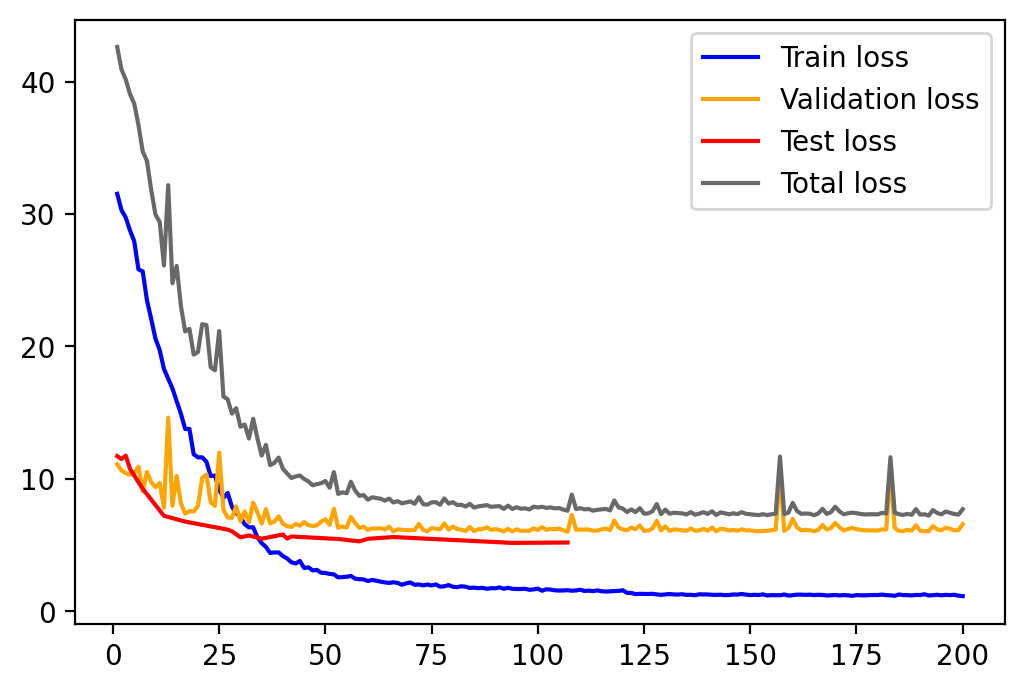

In [19]:
print("Train Loss: {:.4f} | Valid Loss: {:.4f} | Test Loss on Best Model: {:.4f}".format(besttrloss, bestvalloss, besttsloss))
plt.plot(ep,trainloss,color='blue', label = 'Train loss')
plt.plot(ep, validloss, color = 'orange',label = 'Validation loss')
plt.plot(testep, testloss, color = 'red',label = 'Test loss')
plt.plot(ep, totloss, color = 'dimgray',label = 'Total loss')
plt.legend()
plt.show()

In [20]:
tsloss = 0
model.load_state_dict(torch.load('pw_statedict.pt'))
model.eval()
with torch.no_grad():
    for batch_idx, (data, targets, _) in enumerate(test_loader):
        data = Variable(data).to(device)
        targets = Variable(targets.view(targets.shape[0],-1)).to(device)

        
        scores = model(data)
        loss = criterion(scores, targets)

        if batch_idx == 0:
            true_scores = targets.cpu().numpy()
            pred_scores = scores.cpu().numpy()
        else:
            true_scores = np.append(true_scores, targets.cpu().numpy(), axis = 0)
            pred_scores = np.append(pred_scores, scores.cpu().numpy(), axis = 0)


        tsloss += loss.item()


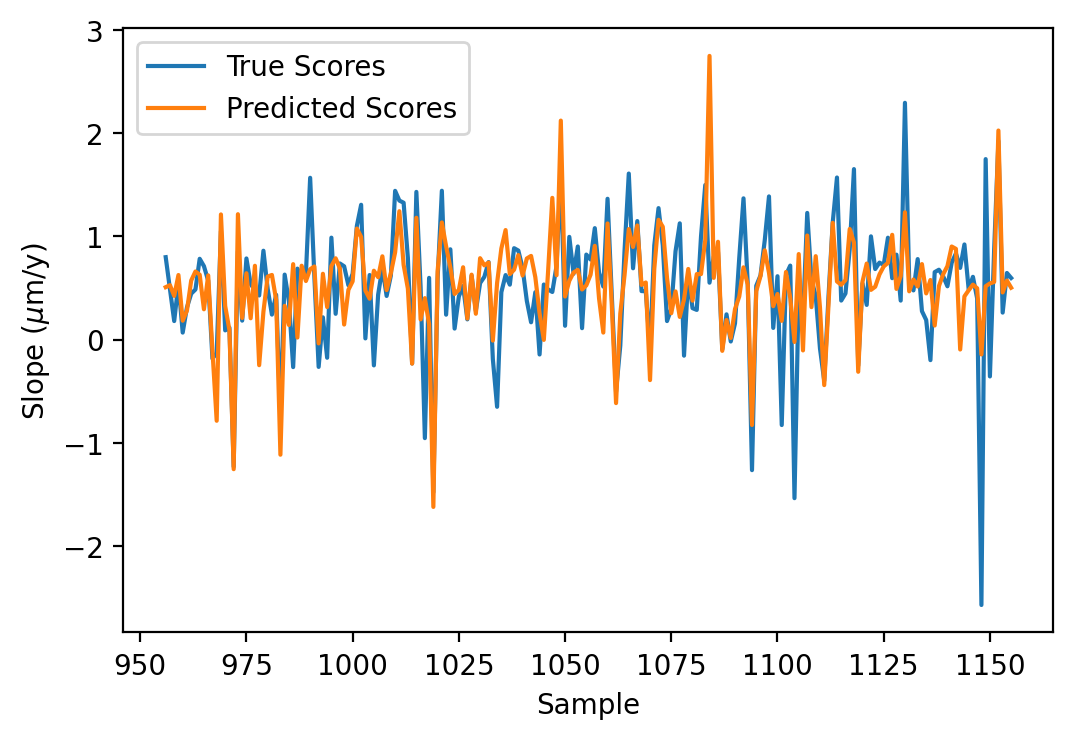

In [21]:
idx = np.array([i+1 for i in range(len(true_scores))])
size = 200
r = np.random.randint(len(idx)-size)
plt.plot(idx[r:r+size], true_scores[r:r+size], label = "True Scores")
plt.plot(idx[r:r+size], pred_scores[r:r+size],label = "Predicted Scores")
plt.ylabel('Slope ($\mu$m/y)')
plt.xlabel('Sample')
plt.legend()
plt.show()

<AxesSubplot:xlabel='Slope ($\\mu$m/y)', ylabel='Count'>

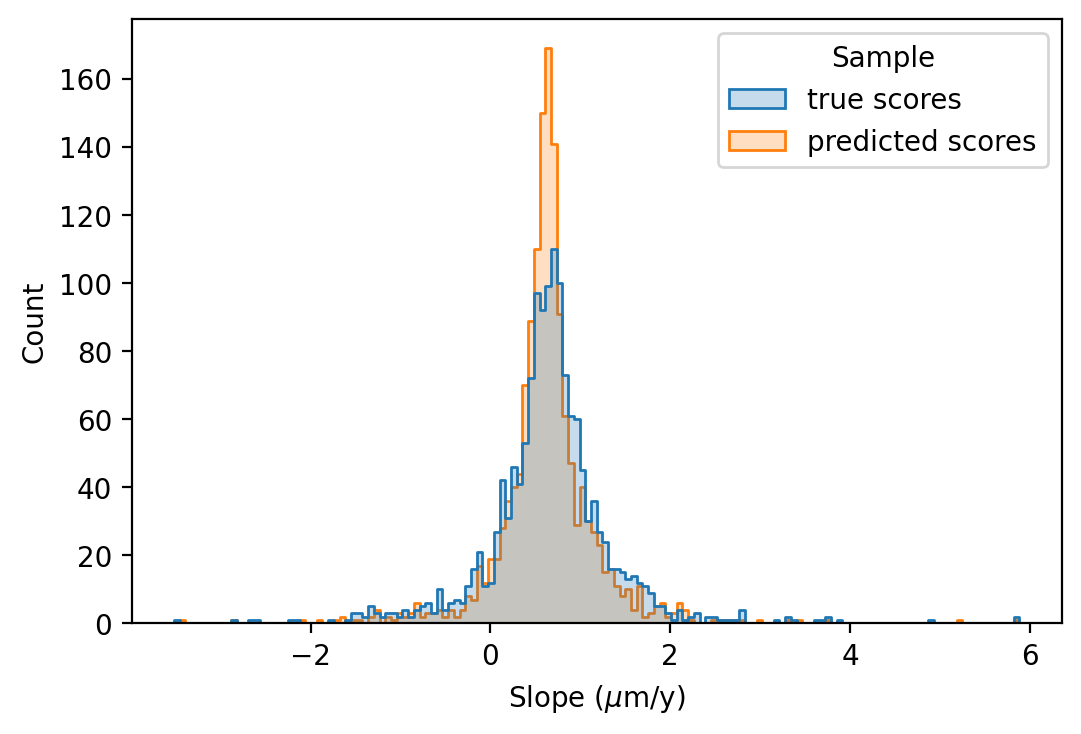

In [22]:
from scipy.stats import ks_2samp
dfx = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': true_scores.ravel().tolist(), 'Sample':'true scores'})
dfy = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': pred_scores.ravel().tolist(), 'Sample':'predicted scores'})
df = pd.concat(axis=0, ignore_index=True, objs=[dfx,dfy])



fig,ax = plt.subplots()
sns.histplot(df,x='Slope ($\mu$m/y)',hue='Sample',ax=ax, element='step')


In [23]:
import pandas as pd
import numpy as np
df.to_csv('predscores.csv')
ndf = pd.DataFrame({'ep': ep,
'train': trainloss,
'valid': validloss,'total':totloss})
ndf.to_csv('losses.csv')

ndf = pd.DataFrame({'ep': testep, 'test':testloss})
ndf.to_csv('testl.csv')

true = np.array(df[df['Sample'] == 'true scores']['Slope ($\mu$m/y)'].tolist())
pred = np.array(df[df['Sample'] == 'predicted scores']['Slope ($\mu$m/y)'].tolist())

from sklearn.metrics import r2_score

coefficient_of_dermination = r2_score(true, pred)
print(coefficient_of_dermination)


0.554749689237133


In [24]:
import scipy
def rsquared(x, y):

    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

In [25]:
rsquared(true, pred)

0.5600531503079424

In [26]:
scipy.stats.spearmanr(true, pred)

SpearmanrResult(correlation=0.6566753754259461, pvalue=1.4333553087381055e-183)

In [27]:
scipy.stats.pearsonr(true, pred)

(0.748366989055465, 3.618664852895574e-266)